## Dataset prepration

In [1]:
import os
import cv2
import numpy as np

In [2]:
bouding_boxes_image_path = "/kaggle/input/cub2002011/CUB_200_2011/bounding_boxes.txt" #1 60.0 27.0 325.0 304.0
classes_image_path = "/kaggle/input/cub2002011/CUB_200_2011/image_class_labels.txt" # 2 002.Laysan_Albatross
image_path_file = "/kaggle/input/cub2002011/CUB_200_2011/images.txt" #1 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
train_test_file = "/kaggle/input/cub2002011/CUB_200_2011/train_test_split.txt" #1 0

file_paths = [
    image_path_file,
    train_test_file,
    bouding_boxes_image_path,
    classes_image_path,
]
# Open all files at once
files = [open(file_path, 'r') for file_path in file_paths]
# # Initialize an empty list to store the line-by-line extracted info
dataset = {}
# # Loop through the files line by line simultaneously
# max_class_names = 20

#only select 10 for each class now
try:
    while True:
        # Read one line from each file
        lines = [(file.name, file.readline().strip()) for file in files]
#         print(len(lines))
        # If any file reaches the end, break the loop
        if any(line == '' for _, line in lines):
            break
#         is_training_set = lines[0][1].split(" ")[0] == '1'
        class_name = lines[3][1].split(" ")[1]
        dataset[lines[0][1].split(" ")[1]] = {
            "is_training": True if lines[1][1].split(" ")[1] == '1' else False,
            "bounding_boxes": lines[2][1].split(" ")[1:],
            "class_name": class_name
        }

        
finally:
    # Make sure to close all files after reading
    for file in files:
        file.close()




In [3]:
### count the datasets
training_dataset_count = 0
testing_dataset_count = 0
class_counts = {}
max_count = 0
min_count = 0
for key,value in dataset.items():
    if value["is_training"] == True:
        training_dataset_count +=1
    else:
        testing_dataset_count +=1
    class_name = value["class_name"]
    if class_name in class_counts.keys():
        class_counts[class_name] += 1
    else:
        class_counts[class_name] = 0
max_class = max(class_counts, key=class_counts.get)
min_class = min(class_counts, key=class_counts.get)
print("Training count={0}".format(training_dataset_count))
print("Testing count={0}".format(testing_dataset_count))
### create embeddings for cub

Training count=5994
Testing count=5794


In [4]:
def crop_image_with_bounding_box(image_cv, bounding_boxes):
    x, y, w, h = bounding_boxes
    # Crop the image using NumPy slicing
    cropped_image = image_cv[y:y+h, x:x+w]
    return cropped_image

def read_image_return_cropped(image_path, bounding_boxes, target_size=(224, 224)):
    # Step 1: Load the image using OpenCV
    image_cv = cv2.imread(image_path)

    # Step 2: Convert BGR to RGB (OpenCV loads images in BGR by default)
    image_cv_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    # Step 3: Crop the image using the bounding box
    cropped_image_cv = crop_image_with_bounding_box(image_cv_rgb, bounding_boxes)

    # Step 4: Resize the cropped image to the target size using cv2
    cropped_image_resized = cv2.resize(cropped_image_cv, target_size)

    # Step 5: Check if the image is grayscale and convert to RGB if necessary
    if len(cropped_image_resized.shape) == 2 or cropped_image_resized.shape[2] == 1:
        cropped_image_resized = cv2.cvtColor(cropped_image_resized, cv2.COLOR_GRAY2RGB)

    # Step 6: Preprocess the image for VGG16 model (normalize pixel values)
    return cropped_image_resized

In [5]:
images_train = []
labels_train = []
images_test = []
labels_test = []
main_path = "/kaggle/input/cub2002011/CUB_200_2011/images/"
count = 0
for key,value in dataset.items():
    (x,y,w,h) = value['bounding_boxes']
    is_training = value["is_training"]
    class_label = value["class_name"]
    image_path = os.path.join(main_path, key)
    cropped_image = read_image_return_cropped(image_path, (int(float(x)), int(float(y)), int(float(w)), int(float(h))))
    if is_training: 
        images_train.append(cropped_image)
        labels_train.append(class_label)
    else:
        images_test.append(cropped_image)
        labels_test.append(class_label)

In [6]:
X_train = np.array(images_train)
y_train = np.array(labels_train)
X_temp = np.array(images_test)
y_temp = np.array(labels_test)

# Verify the shapes
print(f'Images shape: {X_train.shape}')  # (num_images, 224, 224, 3)
print(f'Labels shape: {y_train.shape}')  # (num_images,)
print(f'Images shape: {X_temp.shape}')  # (num_images, 224, 224, 3)
print(f'Labels shape: {y_temp.shape}')  # (num_images,)

Images shape: (5994, 224, 224, 3)
Labels shape: (5994,)
Images shape: (5794, 224, 224, 3)
Labels shape: (5794,)


## Dataset preprocessing

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.applications.resnet import preprocess_input
import numpy as np

# One-hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(np.array(labels_train).reshape(-1, 1))
y_temp = one_hot_encoder.transform(np.array(labels_test).reshape(-1, 1))

# Preprocess images using ResNet's built-in method
X_train = preprocess_input(np.array(images_train).astype(np.float32))
X_temp = preprocess_input(np.array(images_test).astype(np.float32))

# Split test set into validation/test
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,
    random_state=42
)

# Confirm shapes
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")


2025-05-11 01:16:28.722916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746926189.035426      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746926189.118985      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train set: (5994, 224, 224, 3), (5994, 200)
Test set: (4635, 224, 224, 3), (4635, 200)
Validation set: (1159, 224, 224, 3), (1159, 200)


## 2. MODEL

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CenterLossLayer(tf.keras.layers.Layer):
    def __init__(self, num_classes, embedding_dim, margin=1.5, alpha=0.001, **kwargs):
        super(CenterLossLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.margin = tf.cast(margin, tf.float32)
        self.alpha = alpha  # EMA smoothing factor
        self.distance = 0.1  # The length between P1 and P2

        # Initialize center_p1 randomly using a normal distribution
        self.centers_P1 = self.add_weight(name='centers_P1',
                                          shape=(num_classes, embedding_dim),
                                          initializer='random_normal',
                                          trainable=False,
                                          dtype=tf.float32)

        # Create center_p2 without initialization
        self.centers_P2 = self.add_weight(name='centers_P2',
                                          shape=(num_classes, embedding_dim),
                                          initializer='zeros',
                                          trainable=False,
                                          dtype=tf.float32)

    def build(self, input_shape):
        # Generate a random unit vector direction for center_p2
        random_direction = tf.random.normal((self.num_classes, self.embedding_dim))
        unit_vector = random_direction / tf.norm(random_direction, axis=1, keepdims=True)  # Normalize

        # Assign center_p2 to be 'distance' units away from center_p1
        center_p2_value = self.distance * unit_vector
        self.centers_P2.assign(center_p2_value)

        super(CenterLossLayer, self).build(input_shape)
    
    def call(self, inputs):
        embeddings, labels = inputs

        # Ensure embeddings and labels are float32
        embeddings = tf.cast(embeddings, tf.float32)
        labels = tf.argmax(labels, axis=-1, output_type=tf.int32)

        # Step 1: Compute the midpoint for each class (mean of embeddings for each class)
        batch_midpoint = tf.math.unsorted_segment_mean(embeddings, labels, num_segments=self.num_classes)

        # Step 2: Calculate the variance for each class
        squared_diff = tf.square(embeddings - tf.gather(batch_midpoint, labels))
        batch_variance = tf.math.unsorted_segment_mean(squared_diff, labels, num_segments=self.num_classes)

        # Step 3: Compute the standard deviation (sqrt of variance)
        batch_stddev = tf.sqrt(batch_variance)

        # Step 4: Position centers_P1 and centers_P2 around the midpoint
        # Center_P1 closer to the midpoint, Center_P2 further from the midpoint
        batch_centers_P1 = batch_midpoint - 0.5 * batch_stddev  # Center_P1 inside dense region
        batch_centers_P2 = batch_midpoint + 0.5 * batch_stddev  # Center_P2 outside dense region

        # Gather the centers corresponding to the labels
        batch_centers_P1_gathered = tf.gather(batch_centers_P1, labels)
        batch_centers_P2_gathered = tf.gather(batch_centers_P2, labels)

        # Step 5: Update centers using EMA (Exponential Moving Average)
        center_updates_P1 = tf.scatter_nd(tf.expand_dims(labels, 1),
                                          batch_centers_P1_gathered,
                                          shape=tf.shape(self.centers_P1))
        center_updates_P2 = tf.scatter_nd(tf.expand_dims(labels, 1),
                                          batch_centers_P2_gathered,
                                          shape=tf.shape(self.centers_P2))

        # EMA update for centers_P1 and centers_P2
        new_centers_P1 = self.centers_P1 * (1 - self.alpha) + center_updates_P1 * self.alpha
        new_centers_P2 = self.centers_P2 * (1 - self.alpha) + center_updates_P2 * self.alpha

        # Assign updated centers
        self.centers_P1.assign(new_centers_P1)
        self.centers_P2.assign(new_centers_P2)

        # Step 6: Compute distances to all class segments for each embedding
        distances = self.compute_distance_to_segment_all_classes(embeddings)

        # Step 7: Get the correct distances by indexing with labels
        correct_distances = tf.gather_nd(distances, tf.expand_dims(labels, axis=-1), batch_dims=1)

        # Step 8: Mask out correct class distances and find the minimum incorrect distance
        mask = tf.one_hot(labels, depth=self.num_classes, on_value=False, off_value=True)
        masked_distances = tf.where(mask, distances, tf.fill(tf.shape(distances), float('inf')))
        min_incorrect_distances = tf.reduce_min(masked_distances, axis=1)

        # Step 9: Compute the loss
        incorrect_loss = tf.maximum(0.0, self.margin - min_incorrect_distances)
        center_loss = tf.reduce_mean(tf.square(correct_distances))

        return center_loss + tf.reduce_mean(incorrect_loss)


    def compute_distance_to_segment_all_classes(self, embeddings):
        """
        Compute the Euclidean distance from each embedding to the nearest point on the line segment
        defined by P1 and P2 for each class.
        """
        # Get P1 and P2 for all classes
        P1 = self.centers_P1
        P2 = self.centers_P2

        # Vector from P1 to P2 for all classes
        P1_P2 = P2 - P1

        # Expand dims for broadcasting
        P1 = tf.expand_dims(P1, axis=0)
        P2 = tf.expand_dims(P2, axis=0)
        P1_P2 = tf.expand_dims(P1_P2, axis=0)
        embeddings = tf.expand_dims(embeddings, axis=1)

        # Vector from P1 to the embeddings
        P1_emb = embeddings - P1

        # Project embeddings onto the line segment
        proj = tf.reduce_sum(P1_emb * P1_P2, axis=2, keepdims=True) / tf.maximum(tf.reduce_sum(P1_P2 ** 2, axis=2, keepdims=True), 1e-8)

        # Clamp projection to the range [0, 1] to restrict to the segment
        proj_clamped = tf.clip_by_value(proj, 0.0, 1.0)

        # Compute the nearest point on the line segment
        nearest_point = P1 + proj_clamped * P1_P2

        # Compute the Euclidean distance to the nearest point on the segment
        distances = tf.norm(embeddings - nearest_point, axis=2)

        return distances
        
def build_resnet50_center_loss(input_shape, num_classes, embedding_dim, dropout_rate, weight_decay):
    from tensorflow.keras.applications import ResNet50

    # Define input layers
    inputs = layers.Input(shape=input_shape, name='input')
    labels_input = layers.Input(shape=(num_classes,), name='labels_input', dtype='float32')

    # Load ResNet50 as the backbone
    base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')

    # Optionally freeze early layers (adjust as needed)
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Add custom dense layers after ResNet50
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='swish', kernel_regularizer=regularizers.l2(weight_decay),
                     bias_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(weight_decay),
                     bias_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(weight_decay),
                     bias_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1024, activation='swish', kernel_regularizer=regularizers.l2(weight_decay),
                     bias_regularizer=regularizers.l2(0.01))(x)

    # Embedding layer with specified dimension
    x = layers.Dense(embedding_dim, activation='swish')(x)

    # Embedding model
    embedding_model = models.Model(inputs=base_model.input, outputs=x, name='embedding_model_resnet50')

    # Generate embeddings
    embedding = embedding_model(inputs)

    # Classification layer
    logits = layers.Dense(num_classes, activation='softmax', name='classification_layer')(embedding)

    # Center loss
    center_loss_layer = CenterLossLayer(num_classes=num_classes, embedding_dim=embedding_dim)
    center_loss_output = center_loss_layer([embedding, labels_input])

    # Full model
    full_model = models.Model(
        inputs=[inputs, labels_input],
        outputs=[logits, center_loss_output],
        name='full_model_resnet50'
    )

    return embedding_model, full_model


def train_and_evaluate(model, train_generator, val_generator, steps_per_epoch, validation_steps, epochs, center_loss_weight, learning_rate):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)

    history = {
        "train_loss": [],
        "train_class_loss": [],
        "train_center_loss": [],
        "train_acc": [],
        "val_class_loss": [],
        "val_center_loss": [],
        "val_acc": []
    }

    @tf.function
    def train_step(inputs, labels):
        with tf.GradientTape() as tape:
            logits, center_loss = model([inputs, labels], training=True)
            classification_loss = tf.keras.losses.CategoricalCrossentropy()(labels, logits)
            total_loss = classification_loss + center_loss_weight * center_loss

        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        predictions = tf.argmax(logits, axis=-1)
        labels_true = tf.argmax(labels, axis=-1)
        train_acc = tf.reduce_mean(tf.cast(tf.equal(predictions, labels_true), tf.float32))

        return total_loss, classification_loss, center_loss, train_acc

    @tf.function
    def eval_step(inputs, labels):
        logits, center_loss = model([inputs, labels], training=False)
        classification_loss = tf.keras.losses.CategoricalCrossentropy()(labels, logits)

        predictions = tf.argmax(logits, axis=-1)
        labels_true = tf.argmax(labels, axis=-1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels_true), tf.float32))

        return classification_loss, center_loss, accuracy

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training loop
        epoch_loss, epoch_class_loss, epoch_center_loss, epoch_acc = 0, 0, 0, 0
        for step in range(steps_per_epoch):
            inputs_batch, labels_batch = next(train_generator)
            loss, class_loss, center_loss, acc = train_step(inputs_batch, labels_batch)
            epoch_loss += loss
            epoch_class_loss += class_loss
            epoch_center_loss += center_loss
            epoch_acc += acc

        epoch_loss /= steps_per_epoch
        epoch_class_loss /= steps_per_epoch
        epoch_center_loss /= steps_per_epoch
        epoch_acc /= steps_per_epoch

        print(f"Train Loss: {epoch_loss:.4f}, Class Loss: {epoch_class_loss:.4f}, Center Loss: {epoch_center_loss:.4f}, Acc: {epoch_acc:.4f}")

        history["train_loss"].append(epoch_loss)
        history["train_class_loss"].append(epoch_class_loss)
        history["train_center_loss"].append(epoch_center_loss)
        history["train_acc"].append(epoch_acc)

        # Validation loop
        val_class_loss, val_center_loss, val_acc = 0, 0, 0
        for step in range(validation_steps):
            inputs_batch, labels_batch = next(val_generator)
            class_loss, center_loss, acc = eval_step(inputs_batch, labels_batch)
            val_class_loss += class_loss
            val_center_loss += center_loss
            val_acc += acc

        val_class_loss /= validation_steps
        val_center_loss /= validation_steps
        val_acc /= validation_steps

        print(f"Val Class Loss: {val_class_loss:.4f}, Val Center Loss: {val_center_loss:.4f}, Val Acc: {val_acc:.4f}")

        history["val_class_loss"].append(val_class_loss)
        history["val_center_loss"].append(val_center_loss)
        history["val_acc"].append(val_acc)

    return history

# Initialize ImageDataGenerator with augmentation options (without rescaling)
train_datagen = ImageDataGenerator(
    rotation_range=20,           # Randomly rotate images by 20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Zoom in/out
    horizontal_flip=True,        # Random horizontal flipping
    fill_mode='nearest'          # Filling pixels after transformations
)

# Example usage with specified values
input_shape = (224, 224, 3)        # Input shape for images (224x224 RGB)
num_classes = y_train.shape[1]                  # Number of classes in the dataset
embedding_dim = 1000              # Dimensionality of the embedding space
dropout_rate = 0.2               # Dropout rate for regularization
weight_decay = 0.05 #0.005            # L2 regularization weight
center_loss_weight = 0.01 #0.0001          # Weight for center loss
learning_rate = 1e-4               # Learning rate for the optimizer
batch_size = 64                    # Batch size for training
epochs = 40                      # Number of epochs to train

val_datagen = ImageDataGenerator()  # No additional augmentations for validation

# Load and augment training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

# Load validation data
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val)  // batch_size


In [9]:

# Build the model using VGG19 and center loss
embedding_model, full_model = build_resnet50_center_loss(input_shape, num_classes, embedding_dim, dropout_rate, weight_decay)
# Train the model using data generators
history = train_and_evaluate(full_model, train_generator, val_generator, steps_per_epoch, validation_steps, epochs, center_loss_weight, learning_rate)


I0000 00:00:1746926222.228620      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746926222.229358      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40


I0000 00:00:1746926244.512600      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


Train Loss: 5.2031, Class Loss: 5.1508, Center Loss: 5.2238, Acc: 0.0467
Val Class Loss: 4.3424, Val Center Loss: 53.2607, Val Acc: 0.1163
Epoch 2/40
Train Loss: 4.5378, Class Loss: 4.1947, Center Loss: 34.3123, Acc: 0.1805
Val Class Loss: 3.2794, Val Center Loss: 60.0421, Val Acc: 0.3189
Epoch 3/40
Train Loss: 3.8114, Class Loss: 3.2334, Center Loss: 57.7996, Acc: 0.3685
Val Class Loss: 2.7649, Val Center Loss: 49.8709, Val Acc: 0.4908
Epoch 4/40
Train Loss: 3.1944, Class Loss: 2.5119, Center Loss: 68.2497, Acc: 0.5102
Val Class Loss: 2.2947, Val Center Loss: 54.0838, Val Acc: 0.5279
Epoch 5/40
Train Loss: 2.7314, Class Loss: 2.0264, Center Loss: 70.4952, Acc: 0.6144
Val Class Loss: 1.9447, Val Center Loss: 47.6002, Val Acc: 0.6837
Epoch 6/40
Train Loss: 2.3173, Class Loss: 1.6186, Center Loss: 69.8723, Acc: 0.6895
Val Class Loss: 1.7015, Val Center Loss: 47.1659, Val Acc: 0.6812
Epoch 7/40
Train Loss: 1.9990, Class Loss: 1.3288, Center Loss: 67.0200, Acc: 0.7585
Val Class Loss: 1.277

# Save the Model

In [11]:
# Save the history to a .pkl file
import pickle
with open('/kaggle/working/cub_history_standard_resnet.pkl', 'wb') as file:
    pickle.dump(history, file)

In [12]:
# Save the embedding model
embedding_model.save('/kaggle/working/cub_embedding_model_standard_resnet.keras')

# Save the full model
full_model.save('/kaggle/working/cub_full_model_standard_resnet.keras')

## Metric and evaluations

In [13]:
# Load the embedding model
import tensorflow as tf
embedding_model_loaded = tf.keras.models.load_model('/kaggle/working/cub_embedding_model_standard_resnet.keras')

145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step


/tmp/ipykernel_31/995237945.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20b', 31)  # 'tab20b' offers a distinct palette; we can define 31 colors explicitly


ValueError: 'c' argument has 5794 elements, which is inconsistent with 'x' and 'y' with size 4635.

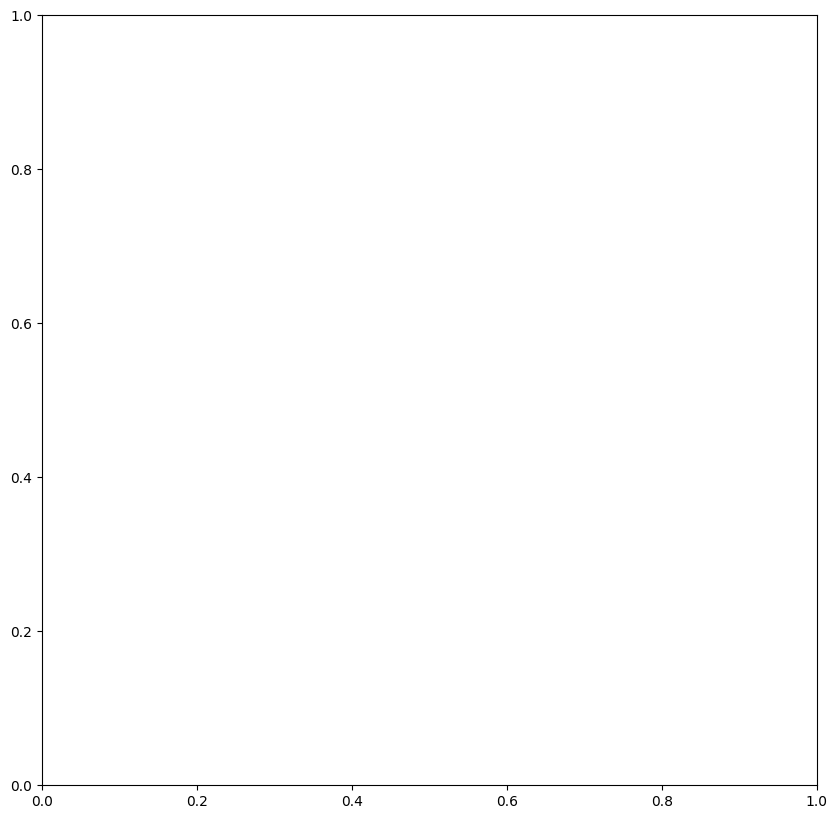

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from matplotlib import cm
from matplotlib.colors import ListedColormap


#embedding_model = models.Model(inputs=model.inputs[0], outputs=model.get_layer('embeddings').output)

# Generate embeddings with 'training=False'
embeddings = embedding_model.predict(X_test)

# Sample image embeddings and labels
# image_embeddings = ... (your embeddings)
# labels_np = ... (your string labels)

# Convert string labels to numeric labels
y_temp_labels = np.argmax(y_temp, axis=1)
numeric_labels = LabelEncoder().fit_transform(y_temp_labels)

# Use t-SNE to reduce the embedding space to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)  # Use your actual embeddings here

# Create a custom color map to support 31 classes
colors = cm.get_cmap('tab20b', 31)  # 'tab20b' offers a distinct palette; we can define 31 colors explicitly

# Plot the 2D embeddings with color based on numeric labels
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=numeric_labels, cmap=colors, s=10)  # Decreased marker size (s=20)

# Add a color legend
legend1 = plt.legend(*scatter.legend_elements(), title="Person")
plt.gca().add_artist(legend1)

# Set plot details
plt.title('t-SNE of Image Embeddings (Color-coded)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Show the plot
plt.show()

In [20]:
from sklearn.metrics import normalized_mutual_info_score
import numpy as np
from sklearn.cluster import KMeans

def evaluation(X, Y, Kset):
    num = X.shape[0]
    classN = np.max(Y) + 1
    kmax = np.max(Kset)
    recallK = np.zeros(len(Kset))
    
    # Compute NMI using KMeans clustering
    kmeans = KMeans(n_clusters=classN).fit(X)
    nmi = normalized_mutual_info_score(Y, kmeans.labels_, average_method='arithmetic')
    
    # Compute Recall@K
    sim = X.dot(X.T)
    minval = np.min(sim) - 1.
    sim -= np.diag(np.diag(sim))
    sim += np.diag(np.ones(num) * minval)
    indices = np.argsort(-sim, axis=1)[:, :kmax]
    YNN = Y[indices]
    
    for i in range(len(Kset)):
        pos = 0.
        for j in range(num):
            if Y[j] in YNN[j, :Kset[i]]:
                pos += 1.
        recallK[i] = pos / num
    
    return nmi, recallK

def calculate_metrics(embedding_model, val_data, labels, k_values):
    # Generate embeddings for the validation set
    embeddings = embedding_model.predict(val_data)
    
    # Convert labels to the appropriate format
    labels = np.argmax(labels, axis=1)  # Assuming labels are one-hot encoded
    
    # Calculate NMI and Recall@K
    nmi_score, recall_scores = evaluation(embeddings, labels, k_values)
    
    return recall_scores, nmi_score

In [21]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128]
recall_scores_test, nmi_score_test = calculate_metrics(embedding_model, X_test, y_test, k_values)

145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
print(recall_scores_test, nmi_score_test)

[0.75080906 0.81445523 0.84983819 0.88263215 0.91995685 0.9562028
 0.97540453 0.98532902] 0.8649237484230071
